# Introduction to Learning Model Parmaters



## CSCI E-83
## Stephen Elston


In the previous lesson we examined several exact inference methods. When we applied these methods inference methods the parameters of the conditional probability distributions (CPD) were assumed known. But, how do we find these parameters in practice? 

In this lesson we will focus on the **learning** for Bayesian network models. There are two aspects of learning for Bayesian networks:  
1. **Parameter estimation** where the parameters of the CPDs of a model are estimated. We focus on this aspect of the problem in this notebook.   
2. **Structure estimation** is the process of estimating the structure of the graphical model. This problem is the subject of another notebook.  

The role of learning in an intelligent agent is illustrated in the figure below. For Bayesian models the learning and inference processes often merge as in the case where evidence is applied.  

<img src="img/Learning.JPG" alt="Drawing" style="width:400px; height:200px"/>
<center> **Learning in an intelligent agent** </center>

## Simple parameter estimation example

In previous lessons we used a belief network of a student looking for a job. As you will recall the student must submit her GRE score, $S$ and her letter of recommendation, $L$. Said that the probability of the GRE score (high, low) was conditional on the student's intelligence, $I$. We had a prior distribution of $I = [0.8, 0.2] = [p(high), p(low)]$. But, how do we estimate the parameters for this distribution?

There are several methods which can be used to estimate the parameters of a distribution including:
- Frequentist **maximum likelihood** or **ML** methods which only require that a likelihood function be specified. 
- Bayesian **maximum a-postiori** or **MAP** methods, which require the specification of both a likelihood function and a prior distribution of the model parameters. 

In this lesson we will focus on the MAP methods, but will also investigate ML methods. MAP methods are inherently Bayesian and therefore provide a more complete picture of distributions. However, MAP methods can be difficult to implement and computationally intensive. Thus in practice, ML methods are used. 



### The Bernoulli and Beta distributions

For this example, we will work with a binary variable with states {0,1}. A **single realization** of such a variable has a **Bernoulli distribution**. The Bernoulli distribution is a **parametric distribution** which we can express as:

$$p(\nu = 1) = \Theta \\
where\\
\nu = an\ observation\\
\Theta = probability\ parameter$$

For a series of observations of a binary valued variable we use the **Binomial distribution**. We call each observation where $\nu = 1$ a **success**. The Binomial distribution of $k$ successes in $n$ trials is then expressed as:

$$p(\nu = k\ |\ \Theta) = \binom{n}{k} \Theta^k (1-\Theta)^{n-k}$$

We want to specify a **Binomial likelihood** in Bayes theorem, we will also need to specify a prior distribution. We pick a prior distribution which is **conjugate** to the likelihood distribution so that the posterior distribution is the same as the prior. We can express this concept as:

$$posterior\_distribution(hypothesis\ |\ data) = \frac{likelihood(data\ |\ hypothesis)* conjugate\_prior(hypothesis)}{marginal\ distribtion\ data }\\
where\\
posterior\_distribution\ is\ same\ family\ as\ prior\_distribution$$

The question is, which distribution is the conjugate to the Binomial distribution? The answer is the **Beta distribution**. We can express the Beta distribution as: 

$$p(x\ |\ \alpha, \beta) = \frac{1}{B(\alpha, \beta)}x^{\alpha - 1}(1-x)^{\beta - 1},\ 0 \le x \le 1\\
where\\
B(\alpha, \beta) = \frac{\Gamma(\alpha) \Gamma(\beta)}{\Gamma(\alpha,\beta)}\\
and\\
\Gamma(x) = Gamma\ function$$

At first glance, the Beta distribution is a bit complicated. But for the most part the normalization with the Gamma function are not terribly important. 

You can develop some intuition about the Beta distribution by plotting it for various values of $\alpha$ and $\beta$. Execute the code in the cell below and examine the results. 

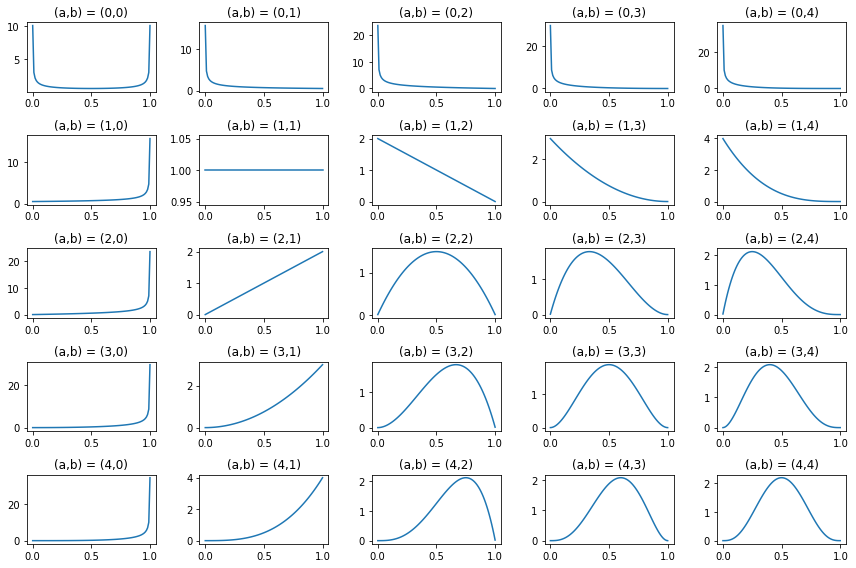

In [78]:
import matplotlib.pyplot as plt
import numpy as np
import itertools as it
import scipy.stats as ss
%matplotlib inline

plt.figure(figsize=(12, 8))

alpha = [.5, 1, 2, 3, 4]
beta = alpha[:]
x = np.linspace(.001, .999, num=100)

for i, (a, b) in enumerate(it.product(alpha, beta)):
    plt.subplot(len(alpha), len(beta), i+1)
    plt.plot(x, ss.beta.pdf(x, a, b))
    plt.title('(a,b) = (%d,%d)' % (a,b))
plt.tight_layout()    

Some points to notice here:

- The range is $0 \le Beta(x) \le 1$.
- If $\alpha \gt \beta$ the distribution is left skewed, if $\alpha \lt \beta$ the distribution is right skewed, and if $\alpha = \beta$ the distribution is symmetric.
- For $\alpha = 1$, $\beta = 1$ the distribution is uniform. 

With these preliminary in mind, we will now look at methods to estimate the parameter of the Binomial likelihood distribution $\theta$.

### Maximum likelihood method

We will not go into the details of **maximum likelihood estimation** (**MLE**). These details can be found in many standard texts on statistics and machine learning including Murphy (Section 7.3), Hastie, Tibshirani and Friedman (Section 2.6), and many others.  


Not surprisingly, in order to perform maximum likelihood estimation, we must define a **likelihood function** for the distribution we are trying to estimate. Given data $\mathcal{V}$ and parameters of the distribution, $\Theta$, we can express a likelihood function as $\mathcal{L}(\Theta, \mathcal{V}) = p(\mathcal{V}\ |\ \Theta)$. In most cases, we will work with the **log likelihood**, $log(p(\mathcal{V}\ |\ \Theta))$. The maximum likelihood estimate or MLE for the parameters is then:

$$\hat{\Theta} \doteq argmax_{\Theta} \{ log(p(\mathcal{V}\ |\ \Theta)) \}$$

In words, we want to find the parameters which maximize the likelihood of the distribution for the data sample. 

Let's use computing the maximum likelihood for the Bernoulli distribution as an example. The likelihood function for the Bernoulli distribution is given a data vector $\mathcal{V}$:

$$L(p) = \prod_{i=1}^n p^{\nu_i}\ (1-p)^{(1 - \nu_i)})$$

The log likelihood is easily computed:

$$\mathcal{l}(p) = log(p) \sum_{i=1}^n \nu_i + log(1-p)  \sum_{i=1}^n (1 - \nu_i)$$

To find the maximum of this function we must find a point where the first partial derivative is zero:

$$\frac{\partial \mathcal{l}(p)}{\partial p} = \frac{\sum_{i=1}^n \nu_i}{p} 
- \frac{\sum_{i=1}^n (1 - \nu_i)}{1-p} = 0$$

The solution is: 

$$p = \frac{1}{n} \sum_{i=1}^n \nu_i$$

The simple result is that the maximum likelihood value of $p$ is just the mean of the data. 

You can verify that the second partial derivative is negative, indicating this is the maximum of the log likelihood function. 

### Bayesian learning

We can now try the Bayesian approach to estimating the parameter $\Theta$. Conceptually you can visualize this process as a directed Bayesian model as shown below. 

<img src="img/PlateDiagram.JPG" alt="Drawing" style="width:400px; height:200px"/>
<center> **Bayes network and plate diagram for parameter estimation** </center>

The parameter $\Theta$ is causal to the vector of data values $\{ \nu^1, \nu^2, \nu^3, \ldots \nu^N \}$. This relationship is shown as a DAG on the left side of the figure above. On the right side of the diagram is a summary using **plate notation**. The plate is short hand for the $N$ values. 

There 

$$p(\Theta\ |\ \nu^1, \nu^2, \nu^3, \ldots \nu^N) \propto p(\Theta) \prod_{n=1}^N p(\nu^n\ |\ \Theta)
= p(\Theta) \prod_{n=1}^N \Theta^{I(\nu^n=1)}(1 - \Theta)^{I(\nu^n=0)}\\
\propto p(\Theta)\ \Theta^{\sum_{n=1}^N I(\nu^n=1)}(1 - \Theta)^{\sum_{n=1}^N I(\nu^n=0)} $$

For a simple binary case of $\{ True, False \}$ the solution can be obtained with the prior distribution $p(\Theta)$ and the counts, $\{ N_T, N_F \}$.

$$p(\Theta\ |\ \nu^1, \nu^2, \nu^3, \ldots \nu^N) \propto p(\Theta)\ \Theta^{N_T} (1 - \Theta)^{N_F}$$  
Given a data vector, $\mathcal{V}$, how do we compute the most probable value of $\Theta$. The solution in this case is relatively easy and can be performed using just counts of the two values, {True, False} or {1,0} and the prior distribution. 

The likelihood given counts can be expressed as follows.

$$\Theta^{\mathcal{C}(\nu_i = 1)} (1-\Theta)^{\mathcal{C}(\nu_i = 0)}\\
where\\
\mathcal{C} = count\ operator$$

Using the above likelihood, the posterior distribution can be expressed as:

$$p(\Theta\ |\ \mathcal{V}) \propto p(\Theta)\ \Theta^{\mathcal{C}(\nu_i = 1)} (1-\Theta)^{\mathcal{C}(\nu_i = 0)}$$

Further details can be found in Murphy, Section 3.3 or Barber, Section 9.4. 

## Computational Example

Now, its time to put all this theory into practice with a computational example. We will continue to work with the student example illustrated below:

<img src="img/LetterDAG.JPG" alt="Drawing" style="width:400px; height:200px"/>
<center> **DAG CPDs for student example** </center>

In this example we will perform the following:

1. Simulate data for the CPDs of the model.
2. Test the CDPs by estimating the parameters using both maximum likelihood and maximum a posteriori methods.
3. Estimate the parameters for the entire model using both MLE and MAP methods. We will be able to examine the effects of different prior distributions. 

### Simulation of CPDs

Creating, testing and debugging simulation software can be tricky. Some of the techniques which can make your life easier are the same as you should use when developing any analytics software, or even software in general. These techniques include:

- Build your simulation as a series of small, easily tested chunks In practice, this means you will build your simulation by creating and testing a set of small functions that comprise the overall model.
- Test each small functional unit individually. These tests should include at least testing some typical cases, as well as boundary or extreme cases. Sensible behavior with extreme or limiting cases is a requirement for a stable simulation. Both tabular and graphical output can be useful for evaluating tests.
- Test your overall simulation each time you add a new functional component. This processes ensures that all the pieces work together. 
- Simulations are inherently stochastic. If you want to create identical numerical results, say for automated testing, set a seed before you begin tests. 

The code in the cell below computes the CPD of D, the difficulty of the course. This part of the simulation is easy, as the samples are just realizations of a Bernoulli distribution. Setting the first parameter of the numpy `binomial` function to 1 computes the result of a single trial, which is a realization of the Bernoulli distribution. There a probability of 0.7 that the machine learning course is difficult. 

In [79]:
## Simulate the binary tables
import numpy as np
import numpy.random as nr
import pandas as pd

nsamp = 25
nr.seed(234)
D_samps = nr.binomial(1, 0.7, nsamp)
D_samps = pd.DataFrame(D_samps, columns = ['D'])
D_samps

D
0   1
1   1
2   0
3   0
4   1
5   1
6   0
7   1
8   1
9   1
10  0
11  1
12  0
13  1
14  0
15  1
16  1
17  1
18  1
19  1
20  1
21  0
22  0
23  1
24  0

The results of above simulation looks reasonable. 

### MLE

But, what happens when we try to estimate the parameters of the distribution? The code in the cell below does the following:

1. Constructs a DAG with a single node.
2. Performs MLE for the model parameters and displays the results

In [80]:
# Defining the Bayesian Model
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

test_model = BayesianModel()
test_model.add_node('D')

# Fitting the data to the model using Maximum Likelihood Estimator
test_model.fit(D_samps, estimator=MaximumLikelihoodEstimator)
print(test_model.get_cpds('D'))

╒══════╤══════╕
│ D(0) │ 0.36 │
├──────┼──────┤
│ D(1) │ 0.64 │
╘══════╧══════╛


The MLE of the parameters are close to, but not exactly the same as, the value we used for the simulation. 

### MAP

Next, we will try a Bayesian estimator. A Dirichlet distribution is used as the prior. We will examine the properties of this distribution in more detail shortly. 

The prior of a Dirichlet distribution is specified as a set of **pseudo counts**. As with any Bayesian estimation problem, we must face the issue of specification of the prior distribution. For this example, we could use any one, or perhaps a combination of the following approaches:
1. Select pseudo counts from previous data sets for the same or similar problems. 
2. Apply expert judgment. 
3. Use an uninformative prior, such as a uniform distribution, in which case the pseudo counts are equal. 

The code in the cell below uses the last approach, a uniform distribution. 

In [81]:
# Fitting the data to the model using Maximum Likelihood Estimator
pseudo_counts = {'D': [20, 20]}
test_model.fit(D_samps, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
print(test_model.get_cpds('D'))

╒══════╤══════════╕
│ D(0) │ 0.446154 │
├──────┼──────────┤
│ D(1) │ 0.553846 │
╘══════╧══════════╛


The MAP estimate of parameters are closer to 0.5. This is expected given the uniform prior. 

### Simulation of Another CPD

There is one more unconditional distribution in our model, I, the intelligence of the student. 

In [82]:
nr.seed(1234)
I_samps = pd.DataFrame(nr.binomial(1, 0.8, nsamp), columns = ['I'])
print(I_samps)

## Estimate the model parameters as a test
test_model = BayesianModel()
test_model.add_node('I')

# Fitting the data to the model using Maximum Likelihood Estimator
test_model.fit(I_samps, estimator=MaximumLikelihoodEstimator)
print(test_model.get_cpds('I'))

    I
0   1
1   1
2   1
3   1
4   1
5   1
6   1
7   0
8   0
9   0
10  1
11  1
12  1
13  1
14  1
15  1
16  1
17  1
18  1
19  0
20  1
21  1
22  1
23  1
24  0
╒══════╤═════╕
│ I(0) │ 0.2 │
├──────┼─────┤
│ I(1) │ 0.8 │
╘══════╧═════╛


As, with the first conditionally independent parameter, these estimates are close, but not exactly the same as the simulation. 

### Simulating Conditionally Dependent Distributions

Up to this point, we have only simulated conditionally independent distributions. Now, we will simulate a conditionally dependent distribution, S, the student's GRE score.  This distribution is dependent only on the student's intelligence, I, the parent variable. 

In [83]:
def sim_bernoulli(p, n = 25):
    """
    Function to compute the vectors with probabilities for each 
    condition (input value) of the dependent variable using the Bernoulli
    distribution. 
    
    The arguments are:
    p - a vector of probabilites of success for each case.
    n - The numer of realizations. 
    """
    temp = np.zeros(shape = (len(p), n))
    for i in range(len(p)): 
        temp[i,:] = nr.binomial(1, p[i], n)
    return(temp)

def selec_dist_1(sims, var, lg):
    """
    Function to integrate the conditional probabilities for
    each of the cases of the parent variable. 
    
    The arguments are:
    sims - the array of simulated realizations with one row for each state of the
           parent variable. 
    var - the vector of values of parent variable used to select the value from the 
          sims array.
    lg - vector of states of possible states of the parent variable. These must be
         in the same order as for the sims array. 
    """
    out = sims[0,:] # Copy of values for first parent state
    var = np.array(var).ravel()
    for i in range(1, sims.shape[0]): # loop over other parent states
        out = [x if u == lg[i] else y for x,y,u in zip(sims[i,:], out, var)]
    return([int(x) for x in out])

## Specify the vector of success probabilites and 
probs = [0.2, 0.8]
bern = sim_bernoulli(probs)

nr.seed(2345)
S_samps = pd.DataFrame(selec_dist_1(bern, I_samps, [0,1]), columns = ['S'])
print(S_samps)

test_model = BayesianModel()
test_model.add_node('S')

# Fitting the data to the model using Maximum Likelihood Estimator
test_model.fit(S_samps, estimator=MaximumLikelihoodEstimator)
print(test_model.get_cpds('S'))

    S
0   1
1   1
2   1
3   1
4   1
5   0
6   1
7   1
8   0
9   0
10  1
11  1
12  1
13  1
14  1
15  1
16  1
17  0
18  1
19  0
20  1
21  1
22  1
23  1
24  0
╒══════╤══════╕
│ S(0) │ 0.24 │
├──────┼──────┤
│ S(1) │ 0.76 │
╘══════╧══════╛


As with the conditionally independent distributions the parameters are close to, but not the same, as the probabilities used for the simulation. 

## Global and Local Parameter Independence

In the foregoing we have only considered the univariate Binomial and Beta distributions. But, real-world problems have many parameters. We need a way to deal with this situation without the mathematical and computational complexity of the full multivariate problem. 

Our approach is to factorize the joint distribution to introduce **global independence** and **local independence**. The global independence assumption allows us to factorize the **posterior distribution** over the conditional tables. The local independence assumption allows us to factor the prior distribution, a necessary condition for the global independence assumption. 

### Global independence assumption

Let's start with the global independence assumption using an example. Recalling the student example of previous lessons, let's consider the parameterized joint distribution of the student's grade in the machine learning course. Using plate notation we call illustrate this part of the DAG as shown here.

<img src="img/Factorizing.JPG" alt="Drawing" style="width:200px; height:300px"/>
<center> **Plate diagram for factorizing joint distribution $p(\Theta_D, \Theta_I, \Theta_G)$** </center>

Let's assume we can factorize the joint distribution as follows.

$$p(\Theta_D, \Theta_I, \Theta_G) = p(\Theta_D)p(\Theta_I)p(\Theta_G)$$

Were $\Theta_D$, $\Theta_I$, and $\Theta_G$ are parameters of the distributions of difficulty, intelligence and grade respectively. 

If we assume the table (vector) of N data values, $\mathcal{V}$, are i.i.d. we can expand the above as:

$$p(\Theta_D, \Theta_I, \Theta_G) = p(\Theta_D)p(\Theta_I)p(\Theta_G) \prod_{n=1}^N p(d^n\ |\ \Theta_D)p(i^n\ |\ \Theta_I)p(g^n\ |\ d^n, i^n, \Theta_G)$$



### Local parameter independence

The local independence assumption allows us to factorize the prior distribution. Let's say that difficulty, $D$, and intelligence $I$, are only binomially distributed. We can factorize the prior distribution. For example: 

$$p(\Theta_G) = p(\Theta_G)^{0,0}p(\Theta_G)^{0,1}p(\Theta_G)^{1,0}p(\Theta_G)^{1,1}$$

Given this factorization we can find a factorization of the posterior distribution. 

$$p(\Theta_G\ |\ \mathcal{V}) \propto p(\mathcal{V}\ |\ \Theta_G) p(\Theta_G)^{0,0}p(\Theta_G)^{0,1}p(\Theta_G)^{1,0}p(\Theta_G)^{1,1}$$

## Introduction to the Categorical and Dirichlet Distributions

Many problems have multiple states or categories. The probabilities of the classes or categories are modeled with the **categorical distribution**. The categorical distribution is the multi-class generalization of the Bernoulli distribution. In fact, this distribution is sometime referred to as the **multinoulli distribution**. For Bayesian learning in these cases, the prior and posterior are modeled with the **Dirichlet distribution**. 

### The Categorical Distribution

We can express the **probability mass** function of the categorical distribution, with $k$ categories, with probability $p_i$ for the ith category as follows.

$$f(x = i\ |\ \boldsymbol{p}) = p_i \\
where\\
\boldsymbol{p} = (p_1, \ldots, p_k),\ and\\ \sum_{i=1}^k p_i = 1.0$$

An alternative formulation uses **Iverson bracket notation**. In this formulation $[x = i] = 1$ and $0$ otherwise. Using this notation the density function of the categorical distribution can be written:

$$f(x = i\ |\ \boldsymbol{p}) = \prod_{i=1}^k p_i^{[x = i]}$$

### The Dirichlet Distribution

In order to perform Bayesian learning with the categorical distribution we need to use Dirichlet distribution as a prior. However, it can be a bit difficult to develop intuition around the behavior of the Dirichlet distribution. We can express the Dirichlet distribution with $n$ categories as follows.

$$f(x_1, x_2, \ldots, x_n; \alpha_1, \alpha_2, \ldots, \alpha_n) = \frac{1}{B(\alpha)} \prod_{i=1}^{n} x_i^{\alpha_i - 1}$$
Where the normalization is the **Beta function**:
$$B(\alpha) = \frac{\prod_{i=1}^{n} \Gamma (\alpha_i) }{\Gamma \big( \sum_{i=1}^{n} \alpha_i \big)}$$
And $\Gamma( x )$ is the Gamma function. 

For our case of interest, the probabilities of the categories are represented by $\{ x_1, x_2, \ldots, x_n \}$ and are constrained by:
$$\sum_{i=1}^{n} x_i = 1\\ x_i \ge 0$$

In fact, in classification problems there is only one category per case, so $[x_i = 1]$ only for the ith category.  

The **concentration parameters** $\{ \alpha_1, \alpha_2, \ldots, \alpha_n \}$, determines how *concentrated* the the distribution is for each class. For the Dirichlet distribution, **prior information** is expressed in terms of the concentration hyperparamters $\boldsymbol{\alpha} = \{ \alpha_1, \alpha_2, \ldots, \alpha_n \}$. The values of $\alpha_i$ are parameterized in terms of **pseudocounts** for each category. The pseudocounts express prior information in two ways:
- Categories with larger pseudocounts have higher prior probabilities. 
- The total sum of pseudocounts expresses the strength of the prior. If the sum of all pseudocounts is relatively large with respect to the number of actual data, the prior will be strong.
- If all $\alpha_i$ are equal the Dirichlet distribution is uniform in the probabilities of the classes.

### Bayesian Parameter Estimation

When computing the Bayesian MAP of $\boldsymbol{p} = (p_1, \ldots, p_k)$ the posterior is Dirichlet distributed. We will skip the considerable amount of algebra and just state that for a category, $i$, with $c_i$ counts out of $N$ total data values, $\boldsymbol{X} = (x_1, x_2, \ldots, x_n)$, the expected posterior MAP of $p_i$ can be expressed:

$$E(p_i\ |\ \boldsymbol{X}, \boldsymbol{\alpha}) = \frac{c_i + \alpha_i}{N + \sum_k \alpha_k}$$

The above expression has an intuitive explanation. Consider the following:
- The probability of a category $i$ increases as the count, $c_i$, increases relative to $N$, the sum of the counts for all categories. 
- As N increases relative to $\sum_k \alpha_k$ the data comes dominate the prior. On the other hand, if there are few actual data the prior will dominate. 

### Maximum Likelihood Estimation

Computing the MLE for the categorical distribution is rather strait forward. The expression is the same as for MAP, but with all $\alpha_i = 0$:

$$E(p_i\ |\ \boldsymbol{X}) = \frac{c_i}{N}$$

In other words, MLE probability for each category is just the faction of counts for that category in the dataset. 

## Computational Example Continued. 

We will now continue to simulate our dataset using the categorical distribution. Here, we will simulate the CPD of the student's grade, G. The basic steps are the same as before, but are a bit more complicated in this case since there are two parent variables and three possible output states. 

In [84]:
def set_class(x):
    """
    Function to flatten the array produced by the numpy.random.multinoulli function. 
    The function tests which binary value of the array of output states is true
    and substitutes an integer for that state. This function only works for up to three
    output states. 
    
    Argument:
    x - The array produced by the numpy.random.multinoulli function. 
    """
    out = []
    for i,j in enumerate(x):
        if j[0] == 1: out.append(0)
        elif j[1] == 1: out.append(1)
        else: out.append(2)   
    return(out)   


def sim_multinoulli(p, n = 25):
    """
    Function to compute the vectors with probabilities for each 
    condition (input value) of the dependent variable using the multinoulli
    distribution. 
    
    The arguments are:
    p - an array of probabilites of success for each possible combination
        of states of the parent variables. Each row in the array are the 
        probabilities for each state of the multinoulli distribution for 
        that combination of parent values.
    n - The numer of realizations. 
    """
    temp = np.zeros(shape = (p.shape[0], n))
    for i in range(p.shape[0]): 
        ps = p[i,:]
        mutlis = nr.multinomial(1, ps, n) 
        temp[i,:] = set_class(mutlis)
    return(temp)

def selec_dist_2(sims, var1, var2, lg1, lg2):
    """
    Function to integrate the conditional probabilities for
    each of the cases of two parent variables. 
    
    The arguments are:
    sims - the array of simulated realizations with one row for each state of the
           union of the parent variables. 
    var1 - the vector of values of first parent variable used to select the value from the 
          sims array.
    var2 - the vector of values of second parent variable used to select the value from the 
          sims array.
    lg1 - vector of states of possible states of the first parent variable. These must be
         in the same order as for the sims array. 
    lg2 - vector of states of possible states of the second parent variable. These must be
         in the same order as for the sims array. 
    """
    out = sims[0,:] # Copy values for first combination of states for parent variables
    ## make sure the parent variables are 1-d numpy arrays.
    var1 = np.array(var1).ravel() 
    var2 = np.array(var2).ravel()
    for i in range(1, sims.shape[0]): # Loop over all comnination of states of the parent variables
        out = [x if u == lg1[i] and v == lg2[i] else y for x,y,u,v in zip(sims[i,:], out, var1, var2)]
    return([int(x) for x in out])

# Specify the array of probabilities for the states. 
probs = np.array([[0.3, 0.05, 0.8,  0.5], [0.4, 0.25, 0.15, 0.3], [0.3, 0.7,  0.05, 0.2]]).transpose()
nr.seed(2343)
sims = sim_multinoulli(probs, nsamp)

## Specify the possible combinations of states of the parent variables. 
I_lg = [0,0,1,1]
D_lg = [0,1,0,1]

## Simualte the CPD
G_samps = pd.DataFrame(selec_dist_2(sims, I_samps, D_samps, I_lg, D_lg), columns = ['G'])
G_samps

G
0   1
1   0
2   0
3   0
4   0
5   2
6   0
7   2
8   2
9   2
10  0
11  2
12  0
13  0
14  0
15  0
16  0
17  0
18  0
19  2
20  0
21  1
22  0
23  0
24  1

With the CPD computed we can estimate the parameters. By using a DAG with only this one variable, the parameters estimated will be for a marginal distribution which makes interpretation a bit difficult. Still, it is worth trying the test.

In [85]:
test_model = BayesianModel()
test_model.add_node('G')

# Fitting the data to the model using Maximum Likelihood Estimator
test_model.fit(G_samps, estimator=MaximumLikelihoodEstimator)
print(test_model.get_cpds('G'))

╒══════╤══════╕
│ G(0) │ 0.64 │
├──────┼──────┤
│ G(1) │ 0.12 │
├──────┼──────┤
│ G(2) │ 0.24 │
╘══════╧══════╛


The parameter estimates seem reasonable, if a bit hard to understand. 

There is one last variable to simulate, the letter, L. This CPD has the parent G, with three states, requiring the specification of three success probabilities.  

In [96]:
probs = [0.9, 0.6, 0.1]
bern = sim_bernoulli(probs, nsamp)

nr.seed(2234)
L_samps = pd.DataFrame(selec_dist_1(bern, G_samps, [0,1,2]), columns = ['L'])
L_samps

L
0    1
1    0
2    0
3    1
4    0
5    1
6    1
7    0
8    0
9    1
10   1
11   1
12   1
13   1
14   1
15   0
16   1
17   0
18   1
19   1
20   1
21   1
22   1
23   1
24   0
25   1
26   0
27   0
28   0
29   0
..  ..
220  1
221  1
222  0
223  0
224  1
225  1
226  1
227  0
228  1
229  1
230  1
231  1
232  1
233  0
234  0
235  1
236  1
237  1
238  0
239  1
240  1
241  1
242  1
243  1
244  1
245  1
246  1
247  1
248  1
249  0

[250 rows x 1 columns]

Finally, we will estimate the parameters of the (marginal) distribution as an approximate test. 

In [87]:
test_model = BayesianModel()
test_model.add_node('L')

# Fitting the data to the model using Maximum Likelihood Estimator
test_model.fit(L_samps, estimator=MaximumLikelihoodEstimator)
print(test_model.get_cpds('L'))

╒══════╤══════╕
│ L(0) │ 0.28 │
├──────┼──────┤
│ L(1) │ 0.72 │
╘══════╧══════╛


## Estimation of Model Parameters

With the simulation created we can now estimate the parameters of the CPDs in our model. First, we will use the maximum likelihood method. Then, we will apply a Bayes method. 

## MLE

As a first step in estimating the parameters, a data frame must be constructed from the variables.  

In [88]:
## Bind the variables into one data frame
dats = pd.concat([I_samps, D_samps, S_samps, G_samps, L_samps], axis = 1)
dats

I  D  S  G  L
0   1  1  1  1  1
1   1  1  1  0  1
2   1  0  1  0  1
3   1  0  1  0  1
4   1  1  1  0  0
5   1  1  0  2  0
6   1  0  1  0  1
7   0  1  1  2  1
8   0  1  0  2  0
9   0  1  0  2  0
10  1  0  1  0  1
11  1  1  1  2  0
12  1  0  1  0  1
13  1  1  1  0  1
14  1  0  1  0  1
15  1  1  1  0  1
16  1  1  1  0  1
17  1  1  0  0  1
18  1  1  1  0  1
19  0  1  0  2  0
20  1  1  1  0  1
21  1  0  1  1  1
22  1  0  1  0  0
23  1  1  1  0  1
24  0  0  0  1  1

With the data frame constructed, we can estimate the parameters of our model. There are a total of 26 model parameters which must be fit using the 25 data points. Not only, but the distribution of the cases are not uniform given the sampling. This model is seriously **under-determined**. This situation will expose one of the significant weaknesses of MLE.    

The code in the cell below performs the following steps for the MLE of the model parameters:
1. The structure of the DAG was defined.
2. The parameters of the model are estimated using the `MaximumLikelihoodEstimator` in the `fit` method. 
3. The parameters of the CDPs are printed. 

In [89]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator, BayesianEstimator

student_model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Learing CPDs using Maximum Likelihood Estimators
student_model.fit(dats, estimator=MaximumLikelihoodEstimator)
for cpd in student_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of D:
╒══════╤══════╕
│ D(0) │ 0.36 │
├──────┼──────┤
│ D(1) │ 0.64 │
╘══════╧══════╛
CPD of G:
╒══════╤══════╤═══════╤══════╤═════════════════════╕
│ D    │ D(0) │ D(0)  │ D(1) │ D(1)                │
├──────┼──────┼───────┼──────┼─────────────────────┤
│ I    │ I(0) │ I(1)  │ I(0) │ I(1)                │
├──────┼──────┼───────┼──────┼─────────────────────┤
│ G(0) │ 0.0  │ 0.875 │ 0.0  │ 0.75                │
├──────┼──────┼───────┼──────┼─────────────────────┤
│ G(1) │ 1.0  │ 0.125 │ 0.0  │ 0.08333333333333333 │
├──────┼──────┼───────┼──────┼─────────────────────┤
│ G(2) │ 0.0  │ 0.0   │ 1.0  │ 0.16666666666666666 │
╘══════╧══════╧═══════╧══════╧═════════════════════╛
CPD of I:
╒══════╤═════╕
│ I(0) │ 0.2 │
├──────┼─────┤
│ I(1) │ 0.8 │
╘══════╧═════╛
CPD of L:
╒══════╤══════╤══════╤══════╕
│ G    │ G(0) │ G(1) │ G(2) │
├──────┼──────┼──────┼──────┤
│ L(0) │ 0.5  │ 0.5  │ 0.5  │
├──────┼──────┼──────┼──────┤
│ L(1) │ 0.5  │ 0.5  │ 0.5  │
╘══════╧══════╧══════╧══════╛
CPD of S:
╒═

The estimates of the conditionally independent variables are as expected. Some of the other CDPs look a bit odd. Notice the 0s in the G variable. The L and S variables are uniformly distributed, which is unexpected. It is possible that much of this behavior is attributable to the under-determined nature of the problem. 

### Bayesian Estimation

Next, we will turn our attention to Bayesian parameter estimation. Recall that we performed Bayesian MAP estimation on the variable D using pseudo counts of $\{ 10,10 \}$, a uniform and modestly strong prior. This gave parameter values of $\{ 0.45, 0.55 \}$.

Let's explore the effect of using different priors. In the cell below, the parameters of the variable D are estimated using a strong prior, with pseudo counts $\{ 50, 50 \}$. This is considered a strong prior since the pseudo counts are larger than the total number of data cases. 

In [99]:
test_model = BayesianModel()
test_model.add_node('D')

# Fitting the data to the model using Bayesian Estimator
pseudo_counts = {'D': [50, 50]}
test_model.fit(D_samps, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
print(test_model.get_cpds('D'))

╒══════╤══════════╕
│ D(0) │ 0.382857 │
├──────┼──────────┤
│ D(1) │ 0.617143 │
╘══════╧══════════╛


With the strong prior, the parameter estimates are close to the proportion of the pseudo counts, that is close to the prior. 

We can also add a **bias** to the parameter estimates through specification of the prior. In the code below the pseudo counts are $\{ 5, 10 \}$. This relatively weak prior favors the positive case over the negative case.

In [91]:
test_model = BayesianModel()
test_model.add_node('D')

# Fitting the data to the model using Bayesian Estimator
pseudo_counts = {'D': [4, 8]}
test_model.fit(D_samps, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
print(test_model.get_cpds('D'))

╒══════╤══════════╕
│ D(0) │ 0.351351 │
├──────┼──────────┤
│ D(1) │ 0.648649 │
╘══════╧══════════╛


These parameters are close to the prior values, despite the relatively weak prior. 

In [100]:
student_model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Learing CPDs using Bayesian Estimators
pseudo_counts = {'D': [4, 6], 'I':[4,6], 'G':[5,2,2], 'S':[4,6], 'L':[4,6]}
student_model.fit(dats, estimator=BayesianEstimator, prior_type='dirichlet', pseudo_counts=pseudo_counts)
for cpd in student_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of D:
╒══════╤══════════╕
│ D(0) │ 0.342857 │
├──────┼──────────┤
│ D(1) │ 0.657143 │
╘══════╧══════════╛
CPD of G:
╒══════╤══════╤════════╤═════════════════════╤═════════════════════╕
│ D    │ D(0) │ D(0)   │ D(1)                │ D(1)                │
├──────┼──────┼────────┼─────────────────────┼─────────────────────┤
│ I    │ I(0) │ I(1)   │ I(0)                │ I(1)                │
├──────┼──────┼────────┼─────────────────────┼─────────────────────┤
│ G(0) │ 0.5  │ 0.6875 │ 0.38461538461538464 │ 0.5454545454545454  │
├──────┼──────┼────────┼─────────────────────┼─────────────────────┤
│ G(1) │ 0.3  │ 0.1875 │ 0.23076923076923078 │ 0.2727272727272727  │
├──────┼──────┼────────┼─────────────────────┼─────────────────────┤
│ G(2) │ 0.2  │ 0.125  │ 0.38461538461538464 │ 0.18181818181818182 │
╘══════╧══════╧════════╧═════════════════════╧═════════════════════╛
CPD of I:
╒══════╤══════════╕
│ I(0) │ 0.257143 │
├──────┼──────────┤
│ I(1) │ 0.742857 │
╘══════╧══════════╛
CPD of L:
╒

Notice the following:
- The parameters of the conditionally independent variables, D and I, are nearly the same as obtained with the MLE method.  
- The parameter estimates for the variable G now seem more as we might expect. 
- The parameter estimates for the variables L and S appear to reflect the prior values of the parameters. 

The stabilization of the parameter estimates for the variable G is an example of **Bayesian regularization**. 

### MLE with more data

You may wonder if simply acquiring more data might help the MLE method behave better. In other words, is the small number of cases the only reason for poor MLE performance. Let's explore this aspect of the problem by simulating 10 times as much data. The code in the cell below simulates 250 cases using the same probabilities as before.

In [93]:
## Let's try a larger sample
nsamp = 250

## First the conditionally independent variables
nr.seed(22234)
D_samps = pd.DataFrame(nr.binomial(1, 0.7, nsamp), columns = ['D'])
nr.seed(2355)
I_samps = pd.DataFrame(nr.binomial(1, 0.8, nsamp), columns = ['I'])

## The variable conditional on two others and with three possible states
probs = np.array([[0.3, 0.05, 0.8,  0.5], [0.4, 0.25, 0.15, 0.3], [0.3, 0.7,  0.05, 0.2]]).transpose()
nr.seed(2334)
sims = sim_multinoulli(probs, nsamp)
I_lg = [0,0,1,1]
D_lg = [0,1,0,1]
G_samps = pd.DataFrame(selec_dist_2(sims, I_samps, D_samps, I_lg, D_lg), columns = ['G'])

## Finally, the two variables conditionally depenent on one other
probs = [0.9, 0.6, 0.1]
nr.seed(2134)
bern = sim_bernoulli(probs, nsamp)
L_samps = pd.DataFrame(selec_dist_1(bern, G_samps, [0,1,2]), columns = ['L'])

probs = [0.2, 0.8]
nr.seed(22234)
bern = sim_bernoulli(probs)
S_samps = pd.DataFrame(selec_dist_1(bern, I_samps, [0,1]), columns = ['S'])

## Now concatenate the columns into one data frame
dats = pd.concat([I_samps, D_samps, S_samps, G_samps, L_samps], axis = 1)
print(dats.shape)
dats.head(10)

(250, 5)


I  D    S  G  L
0  1  1  0.0  1  1
1  1  1  1.0  2  0
2  0  1  0.0  2  0
3  1  1  1.0  0  1
4  0  1  0.0  2  0
5  0  0  1.0  1  0
6  0  1  0.0  1  0
7  1  1  1.0  0  1
8  1  1  1.0  0  0
9  1  0  1.0  0  0

Now, we will compute the parameters for a model using the 250 data cases using MLE.

In [94]:
student_model = BayesianModel([('D', 'G'), ('I', 'G'), ('G', 'L'), ('I', 'S')])

# Learing CPDs using Maximum Likelihood Estimators
student_model.fit(dats, estimator=MaximumLikelihoodEstimator)
for cpd in student_model.get_cpds():
    print("CPD of {variable}:".format(variable=cpd.variable))
    print(cpd)

CPD of D:
╒══════╤══════╕
│ D(0) │ 0.32 │
├──────┼──────┤
│ D(1) │ 0.68 │
╘══════╧══════╛
CPD of G:
╒══════╤══════╤═════════════════════╤══════╤═════════════════════╕
│ D    │ D(0) │ D(0)                │ D(1) │ D(1)                │
├──────┼──────┼─────────────────────┼──────┼─────────────────────┤
│ I    │ I(0) │ I(1)                │ I(0) │ I(1)                │
├──────┼──────┼─────────────────────┼──────┼─────────────────────┤
│ G(0) │ 0.0  │ 0.8571428571428571  │ 0.0  │ 0.5384615384615384  │
├──────┼──────┼─────────────────────┼──────┼─────────────────────┤
│ G(1) │ 1.0  │ 0.14285714285714285 │ 0.25 │ 0.3076923076923077  │
├──────┼──────┼─────────────────────┼──────┼─────────────────────┤
│ G(2) │ 0.0  │ 0.0                 │ 0.75 │ 0.15384615384615385 │
╘══════╧══════╧═════════════════════╧══════╧═════════════════════╛
CPD of I:
╒══════╤═════╕
│ I(0) │ 0.2 │
├──────┼─────┤
│ I(1) │ 0.8 │
╘══════╧═════╛
CPD of L:
╒══════╤══════╤══════╤══════╕
│ G    │ G(0) │ G(1) │ G(2) │
├──────┼

These results are not much different from the ones obtained with 25 cases in the dataset. Evidently, lack of data was not the key problem. Rather, the structure of the model could be the limitation. 

#### Copyright 2018 Stephen F Elston. All rights reserved.